### Predictive Modelling for Medicare Hospital Compare data: Can summary star ratings be predicted from hospital measures?

** Problem: **

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

# Figures inline and set visualization style
%matplotlib inline
sns.set()

In [2]:
# Import data
d = os.path.dirname(os.getcwd())
data_file = os.path.join(d, 'data','processed','hospitals_clean_reordered.csv')
df_hospital = pd.read_csv(data_file)

# View first lines of data
#df_hospital.head(n=4)

In [3]:
# Supervised Learning
# logistic regression, SVM, Decision Tree, K-NN, Random Forest, 

# y holds the response variable- in this case this is the Summary star ratings
print(df_hospital['Summary star rating'].value_counts())
df_hospital['Summary star rating'] = df_hospital['Summary star rating']
y = pd.to_numeric(df_hospital['Summary star rating']).values
y = y.ravel()

# X hold the numerical features
df_numerics_only = df_hospital.select_dtypes(include=[np.number])
X = df_numerics_only.values
print(X)
print("Dimensions of y: {}".format(y.shape))
print("Dimension of X: {}".format(X.shape))
#df_numerics_only.info()

# Drop missing values
df_numerics_noNan = df_numerics_only.dropna()
print("df shape after dropping NaN: {}".format(df_numerics_noNan.shape))

3    1380
4    1335
2     525
5     195
1      55
Name: Summary star rating, dtype: int64
[[  3.    15.4   10.3  ...,   5.      nan    nan]
 [  4.    20.2   12.93 ...,   2.    14.    98.  ]
 [  3.    17.1     nan ...,   1.      nan    nan]
 ..., 
 [  4.      nan    nan ...,   1.     7.    94.  ]
 [  4.    14.8     nan ...,    nan  13.    97.  ]
 [  4.      nan    nan ...,    nan  10.    97.  ]]
Dimensions of y: (3490,)
Dimension of X: (3490, 48)
df shape after dropping NaN: (100, 48)


In [4]:
# Now consider the categorical variables
# X_all holds all features including categorical variables
df = df_hospital.drop('Summary star rating', axis=1)
df = pd.get_dummies(df, drop_first=True)
X_all = df.values
feature_names_all =  df.columns
print("Dimensions of y: {}".format(y.shape))
print("Dimension of X_all: {}".format(X_all.shape))
print("Feature names:",feature_names_all)

Dimensions of y: (3490,)
Dimension of X_all: (3490, 127)
Feature names: Index(['MORT_30_PN', 'PSI_11_POST_RESP', 'PSI_6_IAT_PTX', 'PSI_13_POST_SEPSIS',
       'COMP_HIP_KNEE', 'PSI_3_ULCER', 'PSI_12_POSTOP_PULMEMB_DVT',
       'MORT_30_CABG', 'PSI_10_POST_KIDNEY', 'MORT_30_STK',
       ...
       'Timeliness of care national comparison_Below the national average',
       'Timeliness of care national comparison_Same as the national average',
       'Efficient use of medical imaging national comparison_Below the national average',
       'Efficient use of medical imaging national comparison_Same as the national average',
       'OP_12_Yes', 'SM_PART_NURSE_Y', 'OP_17_Yes', 'SM_PART_GEN_SURG_Y',
       'SM_SS_CHECK_Y', 'OP_25_Yes'],
      dtype='object', length=127)


In [ ]:
# Handcraft features : To select these features common-sense and EDA analysis has been taken into account
select_features = 

In [5]:
# Combine the ratings for experiment
print(df_hospital['Summary star rating'].value_counts())
df2 = df_hospital.copy()
df2.loc[:,'Summary star rating'] = df_hospital.loc[:,'Summary star rating'].replace([2, 3, 4, 5], [1, 2, 3, 3])
print(df2['Summary star rating'].value_counts())

3    1380
4    1335
2     525
5     195
1      55
Name: Summary star rating, dtype: int64
3    1530
2    1380
1     580
Name: Summary star rating, dtype: int64


In [6]:
y_three_ranks = df2['Summary star rating'].values
y_three_ranks = y_three_ranks.ravel()

In [7]:
# Some resampling techniques to address the problem of the imbalanced dataset
# 1- Oversampling (random)
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import Imputer
from collections import Counter

def resample_data(X,y,scheme='SMOTE', imp_strategy='most_frequent'):
    
    X_resampled = X
    y_resampled = y
    imp = Imputer(missing_values='NaN', strategy=imp_strategy, axis=0)
    imp.fit(X)
    X_resampled = imp.transform(X)

    if scheme == 'SMOTE':
        X_resampled, y_resampled = SMOTE(random_state=12).fit_sample(X_resampled, y)
    
    elif scheme == 'random':
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_sample(X_resampled, y)
        
    elif scheme == 'under' :
        rus = RandomUnderSampler(return_indices=True)
        X_resampled, y_resampled, idx_resampled = rus.fit_sample(X_resampled, y)
    
    
    print("Dimensions of y_ros: {}".format(y_resampled.shape))
    print("Dimension of X_ros: {}".format(X_resampled.shape))
    print(sorted(Counter(y_resampled).items()))
    
    return X_resampled, y_resampled

In [8]:
# Plot Confusion matrix (Code snipet taken from Sklearn)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [10]:
# Not yet sure about the plausibility of this?!?!?!?
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

In [39]:
# Construct the pipeline with SVM
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, auc
from sklearn.linear_model import Ridge
from matplotlib.pylab import rcParams
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer, precision_score, cohen_kappa_score, f1_score, recall_score, jaccard_similarity_score, mean_squared_error, explained_variance_score, mean_squared_log_error, r2_score, mean_absolute_error 
from sklearn.preprocessing import label_binarize

#rcParams['figure.figsize'] = 20, 4
score_func = precision_score

def apply_model(X, y, pipeline, parameters, classes = ['1', '2', '3', '4', '5'], kfold = 5, scoring = score_func, 
                valid_param_name=None, grid_score = True, valid_curve = False,  learn_curve = False, classification=True, 
                train_sizes=np.linspace(.1, 1.0, 5), feature_imp=False, feature_names=feature_names_all, nested = False,
                resample = False):
    
    """fit the model to the data
       and print out the performance measures
    """       
    
    # Create train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
    if resample:
        X_train, y_train = resample_data(X_train,y_train,scheme='under', imp_strategy='most_frequent')
    
      
    # Instantiate the GridSearchCV object: cv
    #StratifiedKFold(n_splits=kfold, random_state=0, shuffle=True)
    #scorer = make_scorer(score_func=precision_score, average='micro') 
    #scorer = make_scorer(score_func=cohen_kappa_score)
    #scorer = make_scorer(score_func=score_func) 
    scorer = make_scorer(score_func=score_func, average='micro') 
    #scorer = make_scorer(score_func=score_func, average='micro', beta=0.5)
    #cv = GridSearchCV(pipeline, parameters, scoring=scorer, cv=kfold, return_train_score=True)
    cv = GridSearchCV(pipeline, parameters, scoring=scorer, cv=kfold)

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = cv.predict(X_test)
    #y_pred_proba = cv.predict_proba(X_test)
    
    # Compute and print metrics
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    if classification == False: # if it"s a regression problem
        y_pred = [np.round(y) for y in y_pred]
        
    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Accuracy on the test data: {}".format(accuracy * 100.0))
    #("AUC: {}".format(roc_auc_score(y_test,y_pred_proba)))
    print("Tuned model Parameters: {}".format(cv.best_params_))
    
    # Compute confusion matrix
    cnf_matrix = [[]]
    
    print(classification_report(y_test, y_pred))
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()
        
    if grid_score:
        # Grid Scores
        print('cross-validaiton scores:')
        means_valid = cv.cv_results_['mean_test_score']
        stds_valid = cv.cv_results_['std_test_score']
        for mean_valid, std_valid, params in zip(means_valid, stds_valid, cv.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean_valid, std_valid * 2, params))
            
        print('training scores:')
        means_train = cv.cv_results_['mean_train_score']
        stds_train = cv.cv_results_['std_train_score']    
        for mean_train, std_train, params in zip(means_train, stds_train, cv.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean_train, std_train * 2, params))
            
    if valid_curve:
        plt.title("Validation Curve")
        plt.xlabel("Parameter")
        plt.ylabel("Score")
        plt.ylim(0.0, 1.1)
        plt.semilogx(parameters[valid_param_name], means_train, label="Training score", color="r")
        plt.fill_between(parameters[valid_param_name], means_train - stds_train,
                         means_train + stds_train, alpha=0.2, color="r")
        plt.semilogx(parameters[valid_param_name], means_valid, label="Cross-validation score", color="g")
        plt.fill_between(parameters[valid_param_name], means_valid - stds_valid,
                         means_valid + stds_valid, alpha=0.2, color="g")
        plt.legend(loc="best")
        plt.show()
        
    if learn_curve:
        train_sizes, train_scores, valid_scores = learning_curve(cv, X_train, y_train, cv=kfold, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        valid_scores_mean = np.mean(valid_scores, axis=1)
        valid_scores_std = np.std(valid_scores, axis=1)
        plt.title("Learning Curve")
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        #plt.grid()
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                         valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        plt.legend(loc="best")
        
    if feature_imp:
        plt.figure()
        rcParams['figure.figsize'] = 20, 4
        feat_imp = pd.Series(cv.best_estimator_feature_importances_, feature_names).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
                
       
    return cnf_matrix, cv

In [12]:
# Dummy Classifier (Note that with all these strategies, the predict method completely ignores the input data!)
from sklearn.dummy import DummyClassifier

strategies = ['most_frequent', 'stratified', 'prior', 'uniform']
X_resampled, y_resampled = resample_data(X_all,y,scheme='none', imp_strategy='most_frequent')
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=21)
#X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=21)

for strategy in strategies:
    clf = DummyClassifier(strategy=strategy,random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("accuracy: {}".format(clf.score(X_test, y_test))) 
    print(classification_report(y_test, y_pred))


Dimensions of y_ros: (3490,)
Dimension of X_ros: (3490, 127)
[(1, 55), (2, 525), (3, 1380), (4, 1335), (5, 195)]
accuracy: 0.3982808022922636
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        14
          2       0.00      0.00      0.00       120
          3       0.40      1.00      0.57       278
          4       0.00      0.00      0.00       242
          5       0.00      0.00      0.00        44

avg / total       0.16      0.40      0.23       698

accuracy: 0.3209169054441261
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        14
          2       0.16      0.17      0.17       120
          3       0.38      0.33      0.36       278
          4       0.38      0.43      0.40       242
          5       0.17      0.16      0.16        44

avg / total       0.32      0.32      0.32       698

accuracy: 0.3982808022922636
             precision    recall  f1-score   support

In [ ]:
# Dummy Regressor (not sure on the interpretation of this)
from sklearn.dummy import DummyRegressor

strategies = ['mean', 'median']

for strategy in strategies:
    clf = DummyRegressor(strategy=strategy)
    clf.fit(X_train, y_train)
    print("accuracy: {}".format(clf.score(X_test, y_test))) 


Accuracy on the test data: 55.873925501432666
Tuned model Parameters: {'ridge__alpha': 1000.0}
             precision    recall  f1-score   support

          1       1.00      0.07      0.13        14
          2       0.60      0.26      0.36       120
          3       0.53      0.72      0.61       278
          4       0.58      0.64      0.61       242
          5       1.00      0.07      0.13        44

avg / total       0.60      0.56      0.53       698

Normalized confusion matrix
[[ 0.07142857  0.71428571  0.21428571  0.          0.        ]
 [ 0.          0.25833333  0.69166667  0.05        0.        ]
 [ 0.          0.03597122  0.71942446  0.24460432  0.        ]
 [ 0.          0.00413223  0.3553719   0.64049587  0.        ]
 [ 0.          0.          0.09090909  0.84090909  0.06818182]]


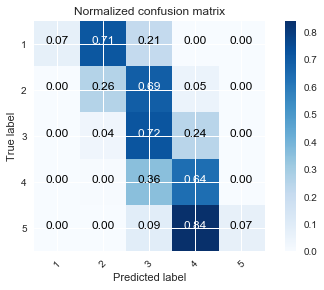

cross-validaiton scores:
0.496 (+/-0.035) for {'ridge__alpha': 9.9999999999999995e-08}
0.496 (+/-0.035) for {'ridge__alpha': 1.2915496650148827e-06}
0.496 (+/-0.035) for {'ridge__alpha': 1.6681005372000593e-05}
0.496 (+/-0.035) for {'ridge__alpha': 0.00021544346900318845}
0.496 (+/-0.035) for {'ridge__alpha': 0.0027825594022071257}
0.496 (+/-0.035) for {'ridge__alpha': 0.035938136638046257}
0.496 (+/-0.035) for {'ridge__alpha': 0.4641588833612782}
0.496 (+/-0.035) for {'ridge__alpha': 5.994842503189421}
0.496 (+/-0.036) for {'ridge__alpha': 77.426368268112782}
0.503 (+/-0.040) for {'ridge__alpha': 1000.0}
training scores:
0.470 (+/-0.010) for {'ridge__alpha': 9.9999999999999995e-08}
0.470 (+/-0.010) for {'ridge__alpha': 1.2915496650148827e-06}
0.470 (+/-0.010) for {'ridge__alpha': 1.6681005372000593e-05}
0.470 (+/-0.010) for {'ridge__alpha': 0.00021544346900318845}
0.470 (+/-0.010) for {'ridge__alpha': 0.0027825594022071257}
0.470 (+/-0.010) for {'ridge__alpha': 0.035938136638046257}
0

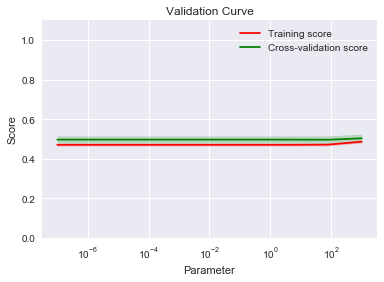

(array([[  1,  10,   3,   0,   0],
        [  0,  31,  83,   6,   0],
        [  0,  10, 200,  68,   0],
        [  0,   1,  86, 155,   0],
        [  0,   0,   4,  37,   3]], dtype=int64),
 GridSearchCV(cv=5, error_score='raise',
        estimator=Pipeline(memory=None,
      steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
     verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=0, solver='auto', tol=0.001))]),
        fit_params=None, iid=True, n_jobs=1,
        param_grid={'ridge__alpha': array([  1.00000e-07,   1.29155e-06,   1.66810e-05,   2.15443e-04,
          2.78256e-03,   3.59381e-02,   4.64159e-01,   5.99484e+00,
          7.74264e+01,   1.00000e+03])},
        pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
        scoring=make_scorer(mean_absolute_error), verbose=0))

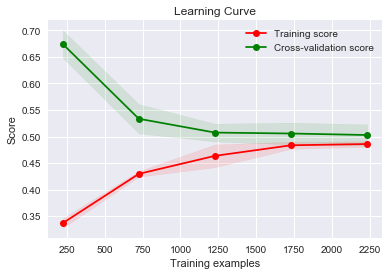

In [13]:
# Perform some linear regression on the data
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

# Ridge linear regression
steps_ridge = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('ridge', Ridge(random_state=0))]
pipeline_ridge = Pipeline(steps_ridge)

parameters_ridge = {'ridge__alpha':np.logspace(-7, 3, 10)}

#print(X_all.shape)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=21)

#print(X_train.shape)
#score_func= mean_squared_error
score_func = mean_absolute_error
#score_func = r2_score
#score_func = explained_variance_score
apply_model(X_all, y, pipeline_ridge,  parameters_ridge, valid_param_name='ridge__alpha', scoring=score_func,
            valid_curve = 1, learn_curve = 1, classification=0, resample = False)



Accuracy on the test data: 56.30372492836676
Tuned model Parameters: {'ridgeClass__alpha': 77.426368268112782}
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        14
          2       0.62      0.42      0.50       120
          3       0.56      0.61      0.58       278
          4       0.55      0.70      0.62       242
          5       0.56      0.11      0.19        44

avg / total       0.56      0.56      0.54       698

Normalized confusion matrix
[[ 0.          0.78571429  0.14285714  0.07142857  0.        ]
 [ 0.          0.41666667  0.49166667  0.09166667  0.        ]
 [ 0.          0.06834532  0.60791367  0.32014388  0.00359712]
 [ 0.          0.          0.2892562   0.69834711  0.01239669]
 [ 0.          0.          0.09090909  0.79545455  0.11363636]]


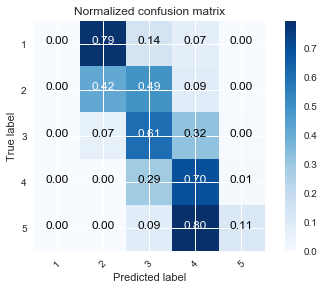

cross-validaiton scores:
0.545 (+/-0.024) for {'ridgeClass__alpha': 9.9999999999999995e-08}
0.545 (+/-0.024) for {'ridgeClass__alpha': 1.2915496650148827e-06}
0.545 (+/-0.024) for {'ridgeClass__alpha': 1.6681005372000593e-05}
0.545 (+/-0.024) for {'ridgeClass__alpha': 0.00021544346900318845}
0.545 (+/-0.024) for {'ridgeClass__alpha': 0.0027825594022071257}
0.545 (+/-0.024) for {'ridgeClass__alpha': 0.035938136638046257}
0.545 (+/-0.024) for {'ridgeClass__alpha': 0.4641588833612782}
0.545 (+/-0.024) for {'ridgeClass__alpha': 5.994842503189421}
0.547 (+/-0.019) for {'ridgeClass__alpha': 77.426368268112782}
0.543 (+/-0.008) for {'ridgeClass__alpha': 1000.0}
training scores:
0.617 (+/-0.007) for {'ridgeClass__alpha': 9.9999999999999995e-08}
0.617 (+/-0.007) for {'ridgeClass__alpha': 1.2915496650148827e-06}
0.617 (+/-0.007) for {'ridgeClass__alpha': 1.6681005372000593e-05}
0.617 (+/-0.007) for {'ridgeClass__alpha': 0.00021544346900318845}
0.617 (+/-0.007) for {'ridgeClass__alpha': 0.0027825

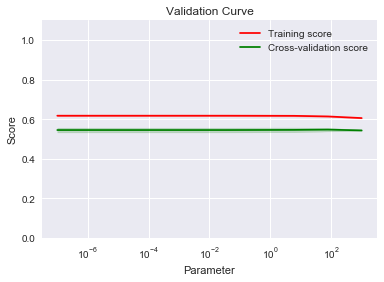

(array([[  0,  11,   2,   1,   0],
        [  0,  50,  59,  11,   0],
        [  0,  19, 169,  89,   1],
        [  0,   0,  70, 169,   3],
        [  0,   0,   4,  35,   5]], dtype=int64),
 GridSearchCV(cv=5, error_score='raise',
        estimator=Pipeline(memory=None,
      steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
     verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridgeClass', RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
         max_iter=None, normalize=False, random_state=0, solver='auto',
         tol=0.001))]),
        fit_params=None, iid=True, n_jobs=1,
        param_grid={'ridgeClass__alpha': array([  1.00000e-07,   1.29155e-06,   1.66810e-05,   2.15443e-04,
          2.78256e-03,   3.59381e-02,   4.64159e-01,   5.99484e+00,
          7.74264e+01,   1.00000e+03])},
        pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
        scoring=

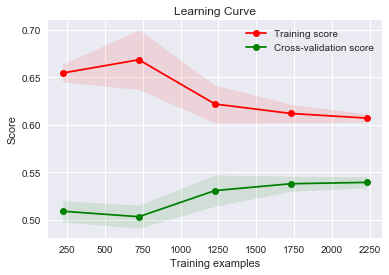

In [16]:
# RidgeClassifier
steps_ridge_cls = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                 ('scaler', StandardScaler()),
                 ('ridgeClass', RidgeClassifier(random_state=0))]
pipeline_ridge_cls = Pipeline(steps_ridge_cls)

parameters_ridge_cls = {'ridgeClass__alpha':np.logspace(-7, 3, 10)}

#print(X_all.shape)

score_func= f1_score
apply_model(X_all, y, pipeline_ridge_cls,  parameters_ridge_cls, valid_param_name='ridgeClass__alpha', scoring=score_func,
            valid_curve = 1, learn_curve = 1, classification=1, resample = False)

Dimensions of y_ros: (3490,)
Dimension of X_ros: (3490, 127)
[(1, 55), (2, 525), (3, 1380), (4, 1335), (5, 195)]
Accuracy on the test data: 43.83954154727794
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        14
          2       0.31      0.89      0.47       120
          3       0.69      0.09      0.15       278
          4       0.54      0.72      0.62       242
          5       0.00      0.00      0.00        44

avg / total       0.52      0.44      0.36       698

Normalized confusion matrix
[[ 0.          1.          0.          0.          0.        ]
 [ 0.          0.89166667  0.00833333  0.1         0.        ]
 [ 0.          0.55755396  0.08633094  0.35611511  0.        ]
 [ 0.          0.23553719  0.04132231  0.7231405   0.        ]
 [ 0.          0.15909091  0.          0.84090909  0.        ]]


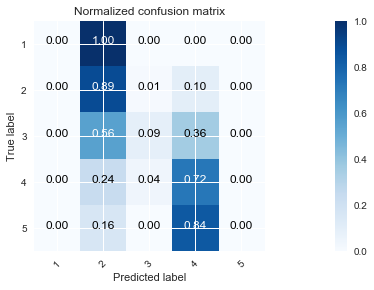

In [37]:
# Exploring the auc scoring
from sklearn.svm import LinearSVC
model_to_set = OneVsRestClassifier(LinearSVC())

parameters = {"estimator__C": [1,2,4,8,16]}


# Create train and test sets
X_resampled, y_resampled = resample_data(X_all,y,scheme='none')
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=21)

scorer = make_scorer(score_func=auc, reorder=True) 
model_tunning = GridSearchCV(model_to_set, param_grid=parameters,
                             scoring=scorer)

model_tunning.fit(X_train, y_train)
y_pred = model_tunning.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test data: {}".format(accuracy * 100.0))
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2','3','4','5'], normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
# Lasso linear regression
steps_lasso = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('lasso', Lasso(random_state=0))]
pipeline_lasso = Pipeline(steps_lasso)

parameters_lasso = {'lasso__alpha':np.logspace(-7, 3, 3)}

apply_model(X_all, y, pipeline_lasso, parameters_lasso, 'lasso__alpha', learn_curve = 1, valid_curve = 1, classification=0)


In [ ]:
# Elasticnet linear regression
steps_elastic = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('elasticnet', ElasticNet(random_state=0))]
pipeline_elastic = Pipeline(steps_elastic)

parameters_elastic = {'elasticnet__l1_ratio':np.logspace(-7, 3, 10)}

apply_model(X_all, y, pipeline_elastic, parameters_elastic, 'elasticnet__l1_ratio', learn_curve = 1, valid_curve = 1, classification=0)


Accuracy on the test data: 51.862464183381086
Tuned model Parameters: {'logreg__C': 1000.0}
             precision    recall  f1-score   support

          1       0.12      0.21      0.15        14
          2       0.46      0.57      0.51       120
          3       0.60      0.47      0.53       278
          4       0.58      0.53      0.55       242
          5       0.37      0.70      0.48        44

avg / total       0.55      0.52      0.52       698

Normalized confusion matrix
[[ 0.21428571  0.71428571  0.07142857  0.          0.        ]
 [ 0.11666667  0.575       0.225       0.08333333  0.        ]
 [ 0.01438849  0.20863309  0.47122302  0.26618705  0.03956835]
 [ 0.01239669  0.04958678  0.23553719  0.52892562  0.17355372]
 [ 0.02272727  0.02272727  0.02272727  0.22727273  0.70454545]]


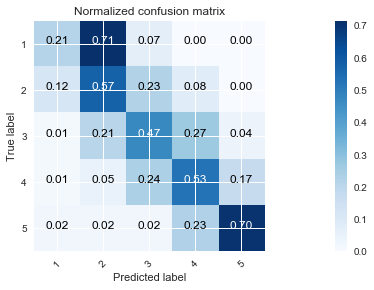

cross-validaiton scores:
0.321 (+/-0.026) for {'logreg__C': 9.9999999999999995e-08}
0.322 (+/-0.027) for {'logreg__C': 1.2915496650148827e-06}
0.342 (+/-0.021) for {'logreg__C': 1.6681005372000593e-05}
0.417 (+/-0.015) for {'logreg__C': 0.00021544346900318845}
0.448 (+/-0.017) for {'logreg__C': 0.0027825594022071257}
0.469 (+/-0.025) for {'logreg__C': 0.035938136638046257}
0.475 (+/-0.029) for {'logreg__C': 0.4641588833612782}
0.476 (+/-0.027) for {'logreg__C': 5.994842503189421}
0.478 (+/-0.036) for {'logreg__C': 77.426368268112782}
0.478 (+/-0.034) for {'logreg__C': 1000.0}
training scores:
0.339 (+/-0.024) for {'logreg__C': 9.9999999999999995e-08}
0.341 (+/-0.024) for {'logreg__C': 1.2915496650148827e-06}
0.358 (+/-0.020) for {'logreg__C': 1.6681005372000593e-05}
0.443 (+/-0.012) for {'logreg__C': 0.00021544346900318845}
0.519 (+/-0.011) for {'logreg__C': 0.0027825594022071257}
0.568 (+/-0.015) for {'logreg__C': 0.035938136638046257}
0.591 (+/-0.018) for {'logreg__C': 0.464158883361

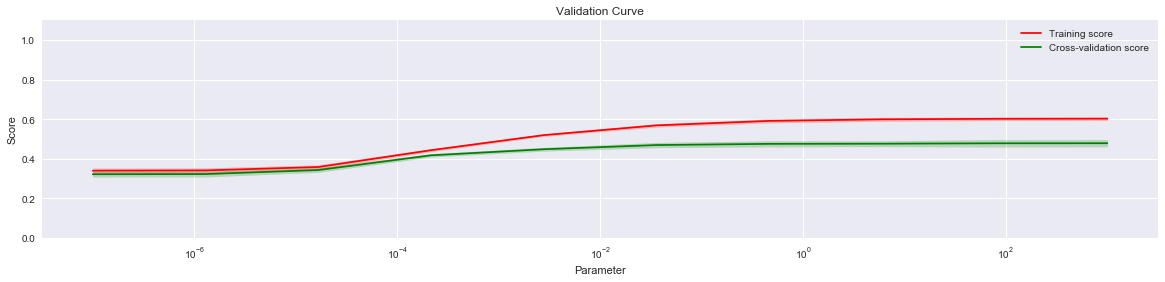

KeyboardInterrupt: 

In [40]:
# Logistic regression for multiclass classification
steps_logreg = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                 ('scaler', StandardScaler()),
                 ('logreg', LogisticRegression(max_iter = 100, solver = 'newton-cg', multi_class = 'multinomial', 
                                              class_weight = 'balanced'))]
                  
pipeline_logreg = Pipeline(steps_logreg)

parameters_logreg = {'logreg__C':np.logspace(-7, 3, 10)}

cnf_matrix, cv = apply_model(X_all, y, pipeline_logreg, parameters_logreg, valid_param_name='logreg__C', 
                             learn_curve = 1, valid_curve = 1, classification=1)

# Apply the classifier using a randomly oversampled dataset to account for the imbalanced data
#cnf_matrix, cv = apply_model(X_ros, y_ros, pipeline_logreg, parameters_logreg, 'logreg__C', 
#                             learn_curve = 1, valid_curve = 1, classification=1)

#cnf_matrix, cv = apply_model(X_smote, y_smote, pipeline_logreg, parameters_logreg, 'logreg__C', 
#                             learn_curve = 1, valid_curve = 1, classification=1)


In [ ]:
# Ordindal regression using the mord package
import mord as m

steps_logclassmord = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                      ('scaler', StandardScaler()),
                      ('logclassmord', m.LogisticIT(max_iter = 100))]
                  
pipeline_logclassmord = Pipeline(steps_logclassmord)

parameters_logclassmord = {'logclassmord__alpha':np.logspace(-7, 3, 10)}

apply_model(X_all, y, pipeline_logclassmord, parameters_logclassmord, 'logclassmord__alpha', 
            learn_curve = 1, valid_curve = 1, classification=1)

In [ ]:
# Now try a linear classification using the support vector classifier
from sklearn.svm import LinearSVC

steps_lsvc = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('lsvc', LinearSVC(random_state=0, loss = 'squared_hinge'))]
pipeline_lsvc = Pipeline(steps_lsvc)

parameters_lsvc = {#'lsvc__loss':['hinge','squared_hinge']}
                   'lsvc__C':np.linspace(0.1,1,11)}

# I see worse resutls on the test data when doing cross-validation. Perhaps I should do nexted cross-validation to get unbiased 
# prediction result on the test data? For example the default of C is one, but if I set it through gridsearch I get seemingly 
# worse results -->  Need to do exhaustive search, i.e., over a range. Look into this more closely however.

# Report results for different scoring
#score_func = precision_score
score_func = f1_score
#score_func = recall_score
#score_func = fbeta_score
#score_func = jaccard_similarity_score

cnf_matrix, cv = apply_model(X_all, y, pipeline_lsvc, parameters_lsvc, scoring = score_func, 
                             valid_param_name = 'lsvc__C',valid_curve=0, learn_curve = 0, classification=1)



In [ ]:
# Now usig the combined rankings
cnf_matrix, cv = apply_model(X_all, y_three_ranks, pipeline_lsvc, parameters_lsvc, learn_curve = 1, classification=1)

# Plot the confusion matrix
class_names = ['1', '2', '3']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# Random Forest Regression (Plot the feature importance)-- It chooses the auto one. Which means all the features. And it is basically bagging.
from sklearn.ensemble import RandomForestRegressor

steps_rfrg = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('rfrg', RandomForestRegressor(random_state=0, class_weight = 'balanced'))]
pipeline_rfrg = Pipeline(steps_rfrg)

parameters_rfrg = {'rfrg__max_depth':[16, 32],
                   'rfrg__n_estimators':[160, 180, 200],
                   'rfrg__max_features':["auto", "sqrt", "log2"]}

cnf_matrix, cv = apply_model(X_all, y, pipeline_rfrg, parameters_rfrg, classification=0)


In [ ]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier

steps_rfcl = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('rfcl', RandomForestClassifier(random_state=0, class_weight = 'balanced'))]
pipeline_rfcl = Pipeline(steps_rfcl)

parameters_rfcl = {'rfcl__max_depth':np.arange(2,128, 20),
                   'rfcl__n_estimators':np.arange(10,200, 10),
                   'rfcl__max_features':["auto", "sqrt", "log2"]}

cnf_matrix, cv = apply_model(X_all, y, pipeline_rfcl, parameters_rfcl, valid_param_name='rfcl__max_depth', 
                             valid_curve = 0, learn_curve = 0, classification=1)

# Plot the confusion matrix
class_names = ['1', '2', '3', '4', '5']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [32]:
# GBM Classifers (Gradient Boosting)
# The overall parameters can be divided into 3 categories:
# 1- Tree-Specific parameters,  2- Boosting parameters, 3- Miscellanous parameters
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics 
from sklearn.grid_search import GridSearchCV 
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

def modelfit(alg, X, y, feature_names, performCV=True, printFeatureImportance=True, cv_folds=5):
   
    #y = label_binarize(y, classes=[1, 2, 3, 4, 5])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
    
    
    #clf_alg = OneVsRestClassifier(alg)
    
    clf_alg = alg
    
    #Fit the algorithm on the data
    clf_alg.fit(X_train, y_train)
        
    #Predict testing set:
    y_pred = clf_alg.predict(X_test)
    #y_predprob = clf_alg.predict_proba(X_test)
    
    #Perform cross-validation:
    #if performCV:
        #cv_score = cross_validation.cross_val_score(clf_alg, X_train, y_train, cv=cv_folds, scoring='accuracy')
        #print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" 
              #% (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Print model report:
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['1','2','3','4','5'], normalize=True,
                      title='Normalized confusion matrix')
    #print("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, y_predprob))
    
            
    #Print Feature Importance:
    if printFeatureImportance:
        plt.figure()
        feat_imp = pd.Series(clf_alg.feature_importances_, feature_names).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


C:\Users\hmirzaee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\hmirzaee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Dimensions of y_ros: (3490,)
Dimension of X_ros: (3490, 127)
[(1, 55), (2, 525), (3, 1380), (4, 1335), (5, 195)]
Model Report
Accuracy : 0.5645
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        14
          2       0.56      0.35      0.43       120
          3       0.55      0.63      0.59       278
          4       0.58      0.68      0.62       242
          5       0.76      0.30      0.43        44

avg / total       0.56      0.56      0.55       698

Normalized confusion matrix
[[ 0.          0.78571429  0.21428571  0.          0.        ]
 [ 0.00833333  0.35        0.56666667  0.075       0.        ]
 [ 0.          0.07194245  0.6294964   0.29856115  0.        ]
 [ 0.          0.00826446  0.29752066  0.67768595  0.01652893]
 [ 0.          0.          0.04545455  0.65909091  0.29545455]]


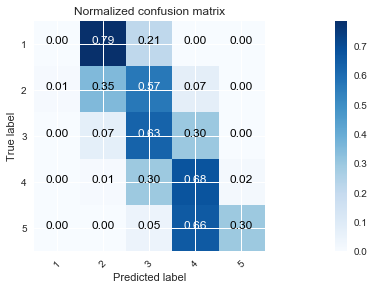

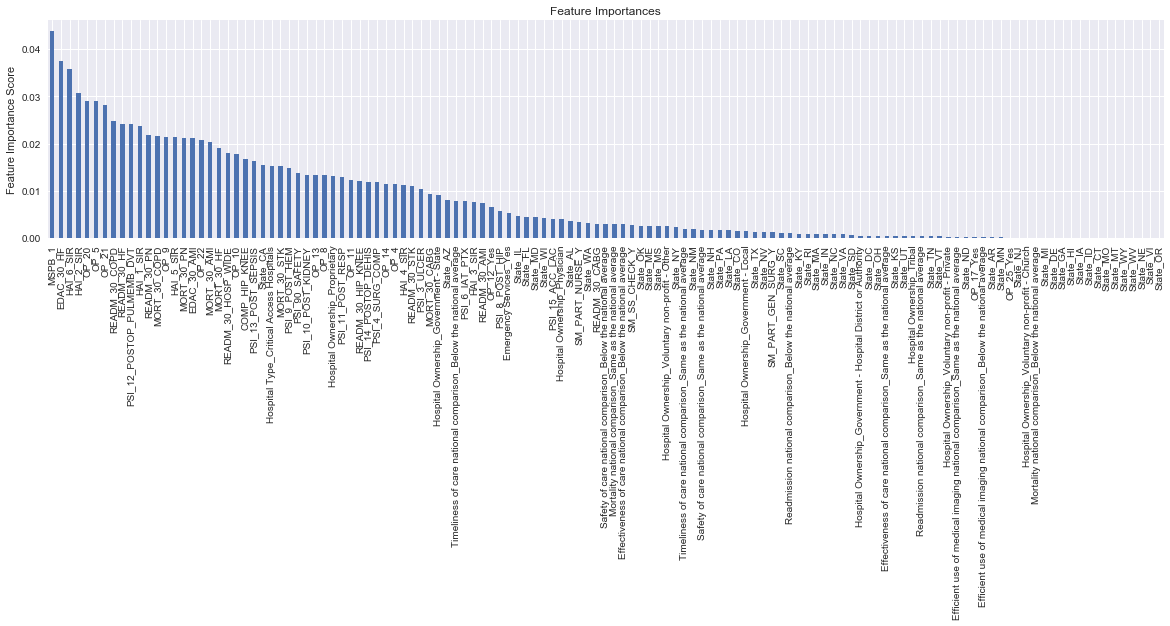

In [33]:
# Let's create a baseline first without any tuning
X_resampled, y_resampled = resample_data(X_all, y, scheme='none', imp_strategy='most_frequent')
gbm0 = GradientBoostingClassifier(random_state=0)
modelfit(gbm0, X_resampled, y_resampled, feature_names_all)

In [ ]:
# Now performing parameter tuning
# There are two types of parameter to be tuned here: 1- Tree-based and 2- boosting parameters
# There are no optimum values for learning rate, low values always work better given that we train on sufficient number of trees
# Notes to keep in mind: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# Let's fix some parameters:
min_samples_split = 2
min_samples_leaf = 1
max_depth = 5
max_features = 'sqrt'
subsample = 0.8

steps_gbm = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
             ('scaler', StandardScaler()),
             ('gbm', GradientBoostingClassifier(random_state=0, learning_rate=0.2))]
pipeline_gbm = Pipeline(steps_gbm)

parameters_gbm = {'gbm__n_estimators':np.arange(2,200, 20)}


cnf_matrix, cv = apply_model(X_all, y, pipeline_gbm, parameters_gbm, 
                             valid_param_name='gbm__n_estimators',valid_curve = 0, 
                             learn_curve = 0, classification=1)
 


In [ ]:
# Tuning tree-specific parameters  (As this can also be a bit expensive, try randomizedSearchCV)
steps_gbm = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
             ('scaler', StandardScaler()),
             ('gbm', GradientBoostingClassifier(random_state=0, learning_rate=0.2, n_estimators = 162))]
pipeline_gbm = Pipeline(steps_gbm)
parameters_gbm_2 = {'gbm__max_depth':np.arange(5,16,2)}
                    #'gbm__min_samples_split':np.arange(2,100,10)}
                    #'gbm__min_samples_leaf':np.arange(1,30, 5),
                    #'gbm__max_features':np.arange(7,20,2)}
cnf_matrix, cv = apply_model(X_resampled, y_resampled, pipeline_gbm, parameters_gbm_2, 
                             valid_curve = 0, learn_curve = 0, classification=1)

In [ ]:
# Tuning tree-specific parameters  (As this can also be a bit expensive, try randomizedSearchCV)
steps_gbm = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
             ('scaler', StandardScaler()),
             ('gbm', GradientBoostingClassifier(random_state=0, learning_rate=0.2, n_estimators=100, max_depth=5))]
pipeline_gbm = Pipeline(steps_gbm)
parameters_gbm_2 = {#'gbm__max_depth':np.arange(5,16,2)}
                    'gbm__min_samples_split':np.arange(2,100,10)}
                    #'gbm__min_samples_leaf':np.arange(1,30, 5),
                    #'gbm__max_features':np.arange(7,20,2)}
cnf_matrix, cv = apply_model(X_resampled, y_resampled, pipeline_gbm, parameters_gbm_2, 
                             valid_curve = 0, learn_curve = 0, classification=1)

In [ ]:
def modelfit(alg, X, y, feature_names, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='accuracy', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='accuracy')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(X, y))
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
# Maybe do a nested cross-validaiton on this one
# Other thing to check is that should I at the end print the classification report on the original non-synthesized data?! 
# What is the appropriate way to interpret these results?
# things to still playaround with: Gridsearch with this, generally use other scoring for gridsearch (look at the book), pay
# attention to other means of playing with imbalanced data

# Read this article :  https://beckernick.github.io/oversampling-modeling/
# Look for the right ways to do cross-validation with oversampling

# XGBoost classifier
# Over all parameters have been divided to:
# 1. General Parameters, 2- Booster Parameters, 3- Learning Task Parameters

#from xgboost import xgb  # Direct xgboost library
from xgboost.sklearn import XGBClassifier  # sklearn wrapper for XGboost
from sklearn.metrics import accuracy_score

X_resampled, y_resampled = resample_data(X_all, y, scheme='SMOTE', imp_strategy='most_frequent')

# Fix some parameter values
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=250,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
#modelfit(xgb1, X_resampled, y_resampled, feature_names_all, useTrainCV=False)

#steps_xgboost = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
#               ('scaler', StandardScaler()),
#               ('xgboost', XGBClassifier())]
#pipeline_xgboost = Pipeline(steps_xgboost)

#parameters_xgboost = {'xgboost__max_depth':np.arange(2,128, 20),
#                      'xgboost__n_estimators':np.arange(10,200, 10)}

#X_resampled, y_resampled = resample_data(X_all, y, scheme='SMOTE', imp_strategy='most_frequent')
# Create train and test sets
#X_resampled_orig, y_resampled_orig = resample_data(X_all, y, scheme='none', imp_strategy='most_frequent')
#X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_resampled_orig, y_resampled_orig, test_size=0.2, random_state=21)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.0, random_state=21)
X_resampled, y_resampled = resample_data(X_train, y_train, scheme='SMOTE', imp_strategy='most_frequent')

model = xgb1
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_train, y_pred))

print("Classificaiton results on all the original test data (missing values treated)")
y_pred = model.predict(X_test_orig)
accuracy = accuracy_score(y_test_orig, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test_orig, y_pred))

print("Classificaiton results on all the original data (missing values treated)")
y_pred = model.predict(X_resampled_orig)
accuracy = accuracy_score(y_resampled_orig, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_resampled_orig, y_pred))




#cnf_matrix, cv = apply_model(X_all, y, pipeline_xgboost, parameters_xgboost, 'xgboost__max_depth', 
#                             valid_curve = 1, learn_curve = 1, classification=1)

# Plot the confusion matrix
#class_names = ['1', '2', '3', '4', '5']
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')
#plt.show()

In [ ]:
# Adaboost regression
from sklearn.ensemble import AdaBoostRegressor

steps_adrg = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('adrg', AdaBoostRegressor(random_state=0))]
pipeline_adrg = Pipeline(steps_adrg)

parameters_adrg = {'adrg__n_estimators':np.arange(10,200, 50),
                   'adrg__learning_rate':np.arange(0.1,1,0.1),
                   'adrg__loss':["linear", "square", "exponential"]}

cnf_matrix, cv = apply_model(X_all, y, pipeline_adrg, parameters_adrg, classification=0)

In [ ]:
# Adaboost Classification
from sklearn.ensemble import AdaBoostClassifier

steps_adcl = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('adcl', AdaBoostClassifier(random_state=0))]
pipeline_adcl = Pipeline(steps_adcl)

parameters_adcl = {'adcl__n_estimators':np.arange(10,200, 50),
                   'adcl__learning_rate':np.arange(0.1,1,0.1)}

cnf_matrix, cv = apply_model(X_all, y, pipeline_adcl, parameters_adcl, classification=1)


In [ ]:
# KNN Regression
from sklearn.neighbors import KNeighborsRegressor

steps_knnrg = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('knnrg', KNeighborsRegressor())]
pipeline_knnrg = Pipeline(steps_knnrg)

parameters_knnrg = {'knnrg__n_neighbors':np.arange(5,30, 5),
                   'knnrg__weights':['uniform','distance']}

cnf_matrix, cv = apply_model(X_all, y, pipeline_knnrg, parameters_knnrg, classification=0)

In [ ]:
# KNN Classification
from sklearn.neighbors import KNeighborsClassifier

steps_knncl = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('knncl', KNeighborsClassifier())]
pipeline_knncl = Pipeline(steps_knncl)

parameters_knncl = {'knncl__n_neighbors':np.arange(5,30, 5),
                   'knncl__weights':['uniform','distance']}

cnf_matrix, cv = apply_model(X_all, y, pipeline_knncl, parameters_knncl, classification=1)

In [ ]:
# Depict the coefficient plots
#plot_coefficients(cv.best_estimator_.named_steps['lsvc'], feature_names_all)

In [ ]:
# SVM with mean imputation strategy using all the 47 numerical features --- SVC also has a probability option, pay attention to that
# Setup the pipeline
steps_svm_mean = [('imputatoin', Imputer(missing_values='NaN', strategy='mean', axis=0)),
                  ('scaler', StandardScaler()),
                  ('SVM', svm.SVC())]
pipeline_svm_mean = Pipeline(steps_svm_mean)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.01, 0.1, 1, 10, 100],
              'SVM__gamma':[0.01, 0.1, 1, 10]}


cnf_matrix = apply_model(X, y, pipeline_svm_mean, parameters)


In [ ]:
# Plot the confusion matrix
class_names = ['1', '2', '3', '4', '5']
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# SVM with median imputation strategy using all the 47 numerical features
# Setup the pipeline with a different imputation strategy
steps_svm_median = [('imputatoin', Imputer(missing_values='NaN', strategy='median', axis=0)),
                    ('scaler', StandardScaler()),
                    ('SVM', svm.SVC())]
pipeline_svm_median = Pipeline(steps_svm_median)

cnf_matrix = apply_model(X, y, pipeline_svm_median, parameters)

In [ ]:
# Plot the confusion matrix
class_names = ['1', '2', '3', '4', '5']
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# SVM with most frequent imputation strategy using all the 47 numerical features
# Setup the pipeline with a different imputation strategy
steps_svm_mf = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                ('scaler', StandardScaler()),
                ('SVM', svm.SVC(random_state=0))]
pipeline_svm_mf = Pipeline(steps_svm_mf)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.01, 0.1, 1, 10, 100],
              'SVM__gamma':[0.01, 0.1, 1, 10]}


#cnf_matrix = apply_model(X, y, pipeline_svm_mf, parameters)

In [ ]:
# Plot the confusion matrix
class_names = ['1', '2', '3', '4', '5']
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# apply the model on all the features
# Specify the hyperparameter space

#parameters = {'SVM__C':[0.01, 0.1, 1, 10, 100],
#              'SVM__gamma':[0.01, 0.1, 1, 10]}

# Now fine tune the search space
parameters = {'SVM__C':[0.8, 0.9, 1, 1.1, 1.3],
              'SVM__gamma':[0.008, 0.009, 0.01, 0.02, 0.03]}
cnf_matrix = apply_model(X_all, y, pipeline_svm_mf, parameters)


parameters = {'SVM__C':[1.25, 1.3, 1.35, 1.4],
              'SVM__gamma':[0.006, 0.007, 0.008, 0.0085]}
cnf_matrix = apply_model(X_all, y, pipeline_svm_mf, parameters)


In [ ]:
# Plot the confusion matrix
class_names = ['1', '2', '3', '4', '5']
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# Combination of PCA and SVM
from sklearn import decomposition

# Setup the pipeline
steps_svm_pca = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                 ('scaler', StandardScaler()),
                 ('pca', decomposition.PCA()),
                 ('SVM', svm.SVC())]
pipeline_svm_pca = Pipeline(steps_svm_pca)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.01, 0.1, 1, 10, 100],
              #'SVM__kernel':['linear','rbf'],
              'SVM__gamma':[0.01, 0.1, 1, 10],
              'pca__n_components':[20, 40, 64]}

apply_model(X_all, y, pipeline_svm_pca, parameters)


In [ ]:
# Specify the hyperparameter space
parameters = {'SVM__C':[0.01, 0.1, 1, 10],
              'SVM__gamma':[0.01, 0.1, 1, 10]}

cnf_matrix = apply_model(X_all, y_three_ranks, pipeline_svm_mf, parameters)

In [ ]:
# Plot the confusion matrix
class_names = ['1', '2', '3']
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# Play with some feature selection strategies
#from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

 
steps_svm_fs = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                ('scaler', StandardScaler()),
                ('anova', SelectKBest()),
                ('SVM', svm.SVC())]
pipeline_svm_fs = Pipeline(steps_svm_fs)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.01, 0.1, 1, 10],
              'SVM__gamma':[0.01, 0.1, 1, 10],
              'anova__k':[10,20,40,80],
              'anova__score_func':[f_classif, mutual_info_classif]}

apply_model(X_all, y_three_ranks, pipeline_svm_fs, parameters)
#apply_model(X_all, y, pipeline_svm_fs, parameters)

In [ ]:
apply_model(X_all, y, pipeline_svm_fs, parameters)

In [ ]:
# Feature selection with RFE seems to be taking a loooong time! 

# First do some linear SVM to select features
#estimator = svm.SVC(kernel="linear")
#selector = feature_selection.RFE(estimator, 40)

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(X_all)
X_all = imp.transform(X_all)
estimator = svm.SVC(kernel="linear")
selector = feature_selection.RFE(estimator, 5)
X_all = selector.fit_transform(X_all,y)

steps_svm_fs_2 = [#('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                  #('feature_selection', selector),
                  ('scaler', StandardScaler()),
                  ('SVM', svm.SVC())]
pipeline_svm_fs_2 = Pipeline(steps_svm_fs_2)

# Specify the hyperparameter space
parameters = {'SVM__C':[ 1],
              'SVM__gamma':[0.01]}

#apply_model(X_all, y, pipeline_svm_fs_2, parameters)


"The situation when the difference between train and validation error is high, but they are both small. Would this be considered underfitting?
"Think about the story telling"
"in the context of my problem is it right that precision is more important than recall? Basically given a set of features the customer wants to know to which class the hospital belongs and how confident the model is"
"CalibratedClassifierCV", look into this if this can be of any use
"Try Random Forest with/ SMOTE Boosting"
"XGBoost w/ hyperparameter optimization"
"SVM w/ Cost sensitive training"
"Make some class specific results"
"Perform KNN (for regression and classification)" KNeightborsRegressor
"Perform Random forest" (also regression with it)
"Peform AdaBoost" also for regression
"SVM for regression"
"Look at SVC ensembe classifier" "Ensemble regressors"
" Draw some ROC curvesTrue Positive vs. False Positives". 
"What is the best way to do that for multi-label classifications? and several parameters"
"Or do presision-recall curve"
"plot the confusion matrix inherent sklearn funcionality"
"look at the sklearn for parameter range of C and gamma and try to change those"
"Try desicion Tree" "Decision Tree with bagging"
"Look into what is being missclassifed. Is there a pattern?"
"Look into ensemble bootstrap techniques"
"If I want probabilities at the end what classifier should I use?"
"My labels are ordered integers. Could I use this information somehow?"
"remove the highly correlated features based on the correlation matrix", "what about ICC and CCC matrices"
"Bootstrapping with DS?"
"Other classifiers to try LDA, KNN, MLP, RF"
"How is KNN used for feature selection?"
"By using the get_support on the pipeline object we can get the chosen features"
"Now one qustion is that i first do some feature selection and train SVM. The other is how do I do feature selection with SVM (in the kernel version?)"
"Try regression, Ranking SVM"
"How about relevance vector machines"
"Ordinal regression (using the mord package)" (regression dor discrete values)
"Idea of nested cross-validation"
"Cosider a plot that shows effect of the sample size"
"Examine the impact of the size of the folds for cross-validation"
"Use techniques to handle imbalanced data": "subdample, oversample, re-weight sample points, clustering to reduce majority class, recalibrate classifer output"
"subsample for each tree in random forest"

In [ ]:
# Loop over and add one by one (computing all combination is not cost effective, therefore, we only add one-by-one)
df_hospital.info()